Attempting to load dataset with different delimiters...
Successfully loaded with tab delimiter
Dataset shape: (7072, 8)

Column names:
['HH_ID', 'Member_Age_Orig', 'Member_ID', 'Member_Gender_Orig', 'HEIGHT', 'WEIGHT', 'Mod_act', 'Vig_act']

First few rows:
   HH_ID Member_Age_Orig  Member_ID Member_Gender_Orig HEIGHT WEIGHT Mod_act  \
0      1              37       2055                  1    5.1    190      32   
1      1              37       3841                  2    5.5    170      30   
2      1               2       4633                  2            30           
3      1               2       4735                  1            32           
4      1               1       4917                  1            28           

  Vig_act  
0          
1       2  
2          
3          
4          

Cleaning data...
Cleaned column names: ['HH_ID', 'Member_Age_Orig', 'Member_ID', 'Member_Gender_Orig', 'HEIGHT', 'WEIGHT', 'Mod_act', 'Vig_act']
Expected columns: ['HH_ID', 'Member_Age_Ori

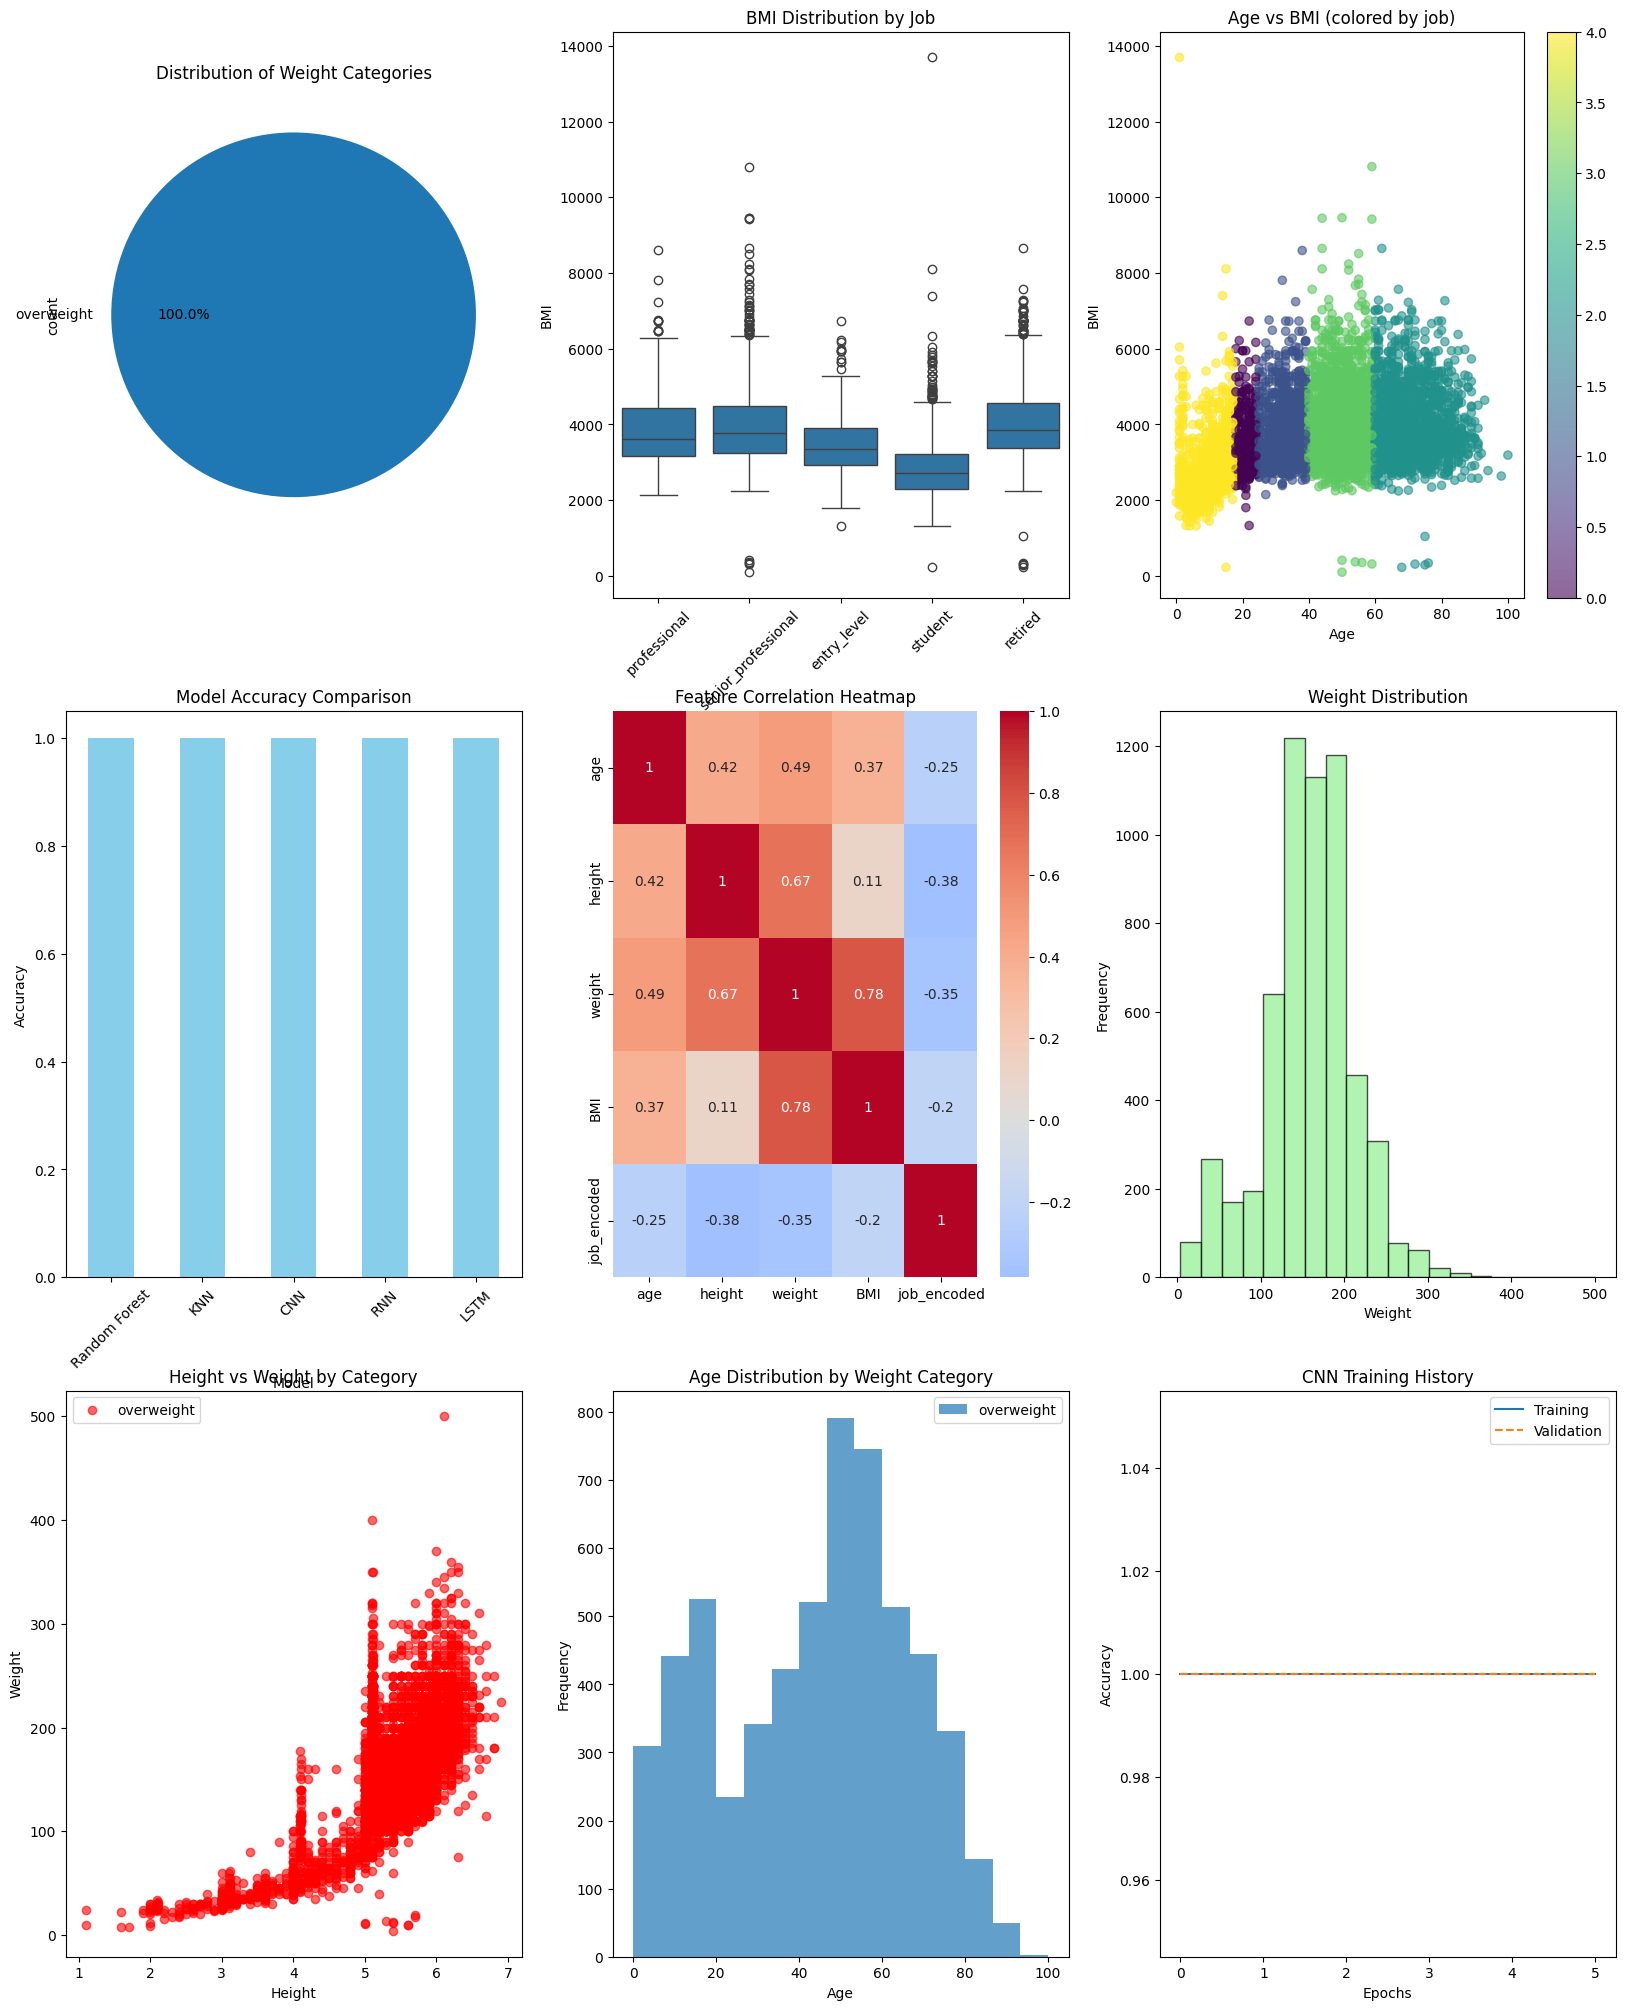

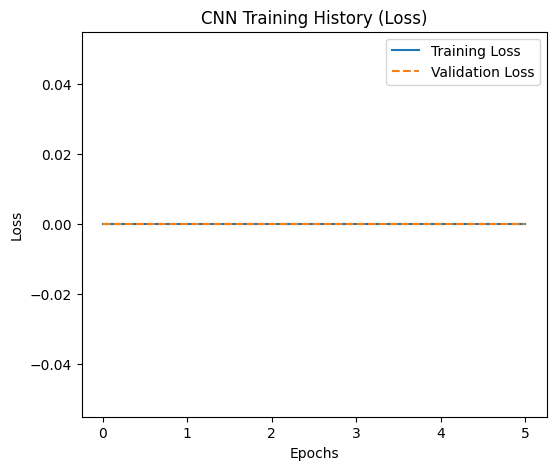

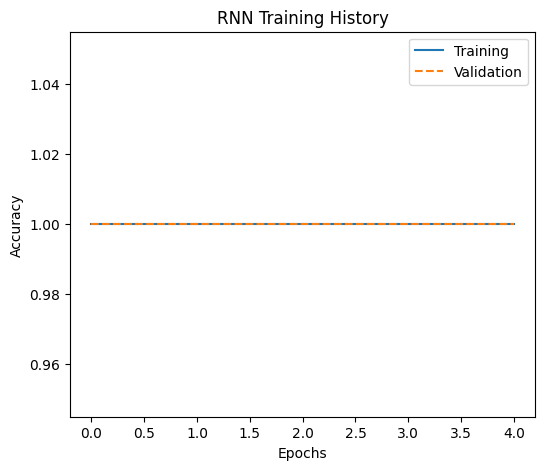

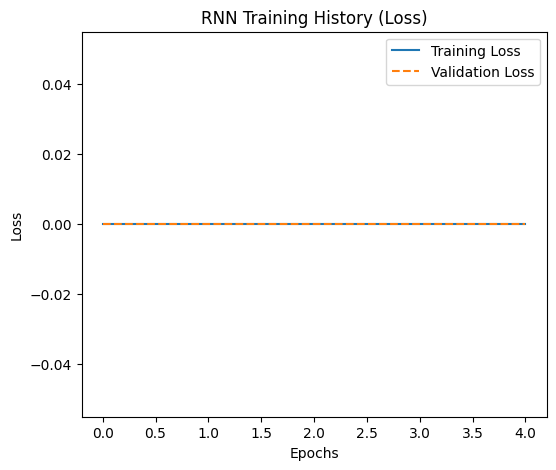

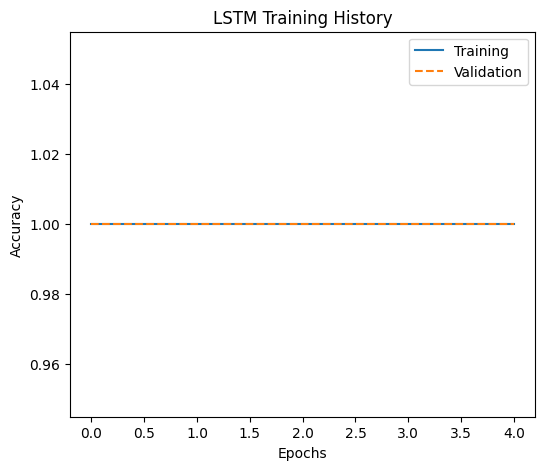

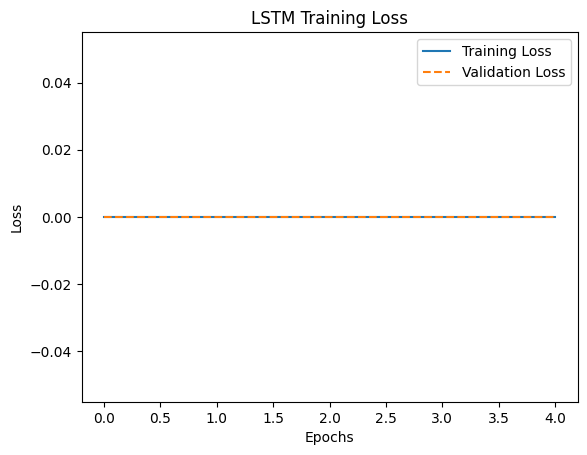

<Figure size 640x480 with 0 Axes>


CREATING HEALTH KNOWLEDGE BASE
Health knowledge base created and saved to C:/DATA/kb_healthGuide.json

G. MODEL DEPLOYMENT
Health Prediction System Ready!

Example prediction:

HEALTH PREDICTION REPORT
Personal Information:
  Job: professional
  Age: 30 years
  Height: 5.6 feet
  Weight: 165 pounds
  BMI: 3698.82

Prediction: OVERWEIGHT
Model: Predicted using Random Forest
Definition: BMI 25 or higher

Health Risks:
  • Type 2 diabetes
  • Heart disease
  • High blood pressure
  • Sleep apnea
  • Certain cancers

Recommendations:
  • Create a caloric deficit through diet and exercise
  • Reduce portion sizes
  • Increase physical activity gradually
  • Focus on whole, unprocessed foods
  • Consider consulting with healthcare professionals

Foods to Include:
  • Vegetables and fruits
  • Lean proteins
  • Whole grains in moderation
  • Low-fat dairy
  • Limit processed foods and sugary drinks

Job-Specific Advice:
  • Take regular breaks from desk work
  • Manage work stress effectivel

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, SimpleRNN, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Load and examine the dataset - try different delimiters
print("Attempting to load dataset with different delimiters...")

try:
    # Try tab delimiter first (since the attachment shows TSV format)
    df = pd.read_csv('C:/DATA-4/data_4.2.csv', delimiter='\t')
    print("Successfully loaded with tab delimiter")
except:
    try:
        # Try comma delimiter
        df = pd.read_csv('C:/DATA-4/data_4.2.csv', delimiter=',')
        print("Successfully loaded with comma delimiter")
    except:
        try:
            # Try semicolon delimiter
            df = pd.read_csv('C:/DATA-4/data_4.2.csv', delimiter=';')
            print("Successfully loaded with semicolon delimiter")
        except:
            # Default read
            df = pd.read_csv('C:/DATA-4/data_4.2.csv')
            print("Loaded with default settings")

print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Clean the data - handle missing values and convert data types
print("\nCleaning data...")

# Remove any leading/trailing spaces from column names
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('"', '')  # Remove quotes if present
print("Cleaned column names:", df.columns.tolist())

# Check if we have the expected columns
expected_columns = ['HH_ID', 'Member_Age_Orig', 'Member_ID', 'Member_Gender_Orig', 'HEIGHT', 'WEIGHT', 'Mod_act', 'Vig_act']
actual_columns = df.columns.tolist()

print(f"Expected columns: {expected_columns}")
print(f"Actual columns: {actual_columns}")

# Map actual columns to expected ones
column_mapping = {}
if len(actual_columns) >= 8:
    for i, expected in enumerate(expected_columns):
        if i < len(actual_columns):
            column_mapping[actual_columns[i]] = expected
    
    # Rename columns
    df = df.rename(columns=column_mapping)
    print(f"Renamed columns: {df.columns.tolist()}")

# Clean and prepare the data
# Handle missing values and data type conversion
age_col = 'Member_Age_Orig'
height_col = 'HEIGHT' 
weight_col = 'WEIGHT'

# Replace empty strings and spaces with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.replace('', np.nan)

# Drop rows with missing essential data
print(f"Original dataset size: {len(df)}")
df = df.dropna(subset=[age_col, height_col, weight_col])
print(f"After removing missing values: {len(df)}")

# Convert to numeric, handling any conversion errors
df['age'] = pd.to_numeric(df[age_col], errors='coerce')
df['height'] = pd.to_numeric(df[height_col], errors='coerce') 
df['weight'] = pd.to_numeric(df[weight_col], errors='coerce')

# Remove any rows that couldn't be converted to numeric
df = df.dropna(subset=['age', 'height', 'weight'])
df = df[(df['age'] > 0) & (df['height'] > 0) & (df['weight'] > 0)]

print(f"After numeric conversion and filtering: {len(df)}")

# Create job categories based on age groups
df['job'] = 'general'  # Default category
df.loc[df['age'] < 18, 'job'] = 'student'
df.loc[(df['age'] >= 18) & (df['age'] < 25), 'job'] = 'entry_level'
df.loc[(df['age'] >= 25) & (df['age'] < 40), 'job'] = 'professional' 
df.loc[(df['age'] >= 40) & (df['age'] < 60), 'job'] = 'senior_professional'
df.loc[df['age'] >= 60, 'job'] = 'retired'

print(f"Final dataset shape: {df.shape}")

# ============================================================================
# b. Show the distribution of the dataset
# ============================================================================
print("\n" + "="*60)
print("B. DATASET DISTRIBUTION")
print("="*60)

# Calculate BMI and create weight categories
# Convert height from feet.inches to feet (e.g., 5.11 -> 5.92 feet)
def convert_height_to_feet(height):
    """Convert height in feet.inches format to decimal feet"""
    if pd.isna(height):
        return np.nan
    
    # If height is greater than 10, assume it's in feet.inches format
    if height >= 10:
        feet = int(height)
        inches = (height - feet) * 100  # Get the decimal part as inches
        return feet + inches/12
    else:
        # Already in decimal feet format
        return height

df['height_feet'] = df['height'].apply(convert_height_to_feet)

# Calculate BMI (weight in pounds, height in feet)
df['BMI'] = df['weight'] / (df['height_feet'] ** 2) * 703

def categorize_bmi(bmi):
    if pd.isna(bmi) or bmi <= 0:
        return 'unknown'
    elif bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'  
    else:
        return 'overweight'

df['weight_category'] = df['BMI'].apply(categorize_bmi)
df = df[df['weight_category'] != 'unknown']  # Remove unknown categories

print("Dataset statistics:")
print(df[['age', 'height', 'weight', 'BMI']].describe())
print("\nWeight category distribution:")
print(df['weight_category'].value_counts())
print("\nJob distribution:")
print(df['job'].value_counts())

# ============================================================================
# c. Using 5 basic ML models for classification
# ============================================================================
print("\n" + "="*60)
print("C. BASIC ML MODELS")
print("="*60)

# Prepare data
le_job = LabelEncoder()
df['job_encoded'] = le_job.fit_transform(df['job'])
le_weight = LabelEncoder()
y = le_weight.fit_transform(df['weight_category'])

X = df[['job_encoded', 'age', 'BMI']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

ml_results = {}

for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        ml_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'predictions': y_pred
        }
        
        print(f"{name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print()
    except Exception as e:
        print(f"Error training {name}: {e}")

# ============================================================================
# d. Build CNN, RNN, LSTM models (SỬA ĐỂ TĂNG DAO ĐỘNG)
# ============================================================================
print("\n" + "="*60)
print("D. DEEP LEARNING MODELS") 
print("="*60)

from tensorflow.keras.callbacks import EarlyStopping

# Chuẩn bị dữ liệu cho DL
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y))

y_train_cat = tf.keras.utils.to_categorical(y_train, n_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, n_classes)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Tách train/val để tránh leakage
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train_reshaped, y_train_cat, test_size=0.2, random_state=42, stratify=y_train
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

dl_results = {}

# ================== CNN ==================
print("Training CNN...")
try:
    cnn_model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_features, 1)),
        MaxPooling1D(pool_size=1),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])

    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    cnn_history = cnn_model.fit(
        X_train_dl, y_train_dl,
        validation_data=(X_val_dl, y_val_dl),
        epochs=20,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

    cnn_pred = cnn_model.predict(X_test_reshaped)
    cnn_pred_classes = np.argmax(cnn_pred, axis=1)

    cnn_accuracy = accuracy_score(y_test, cnn_pred_classes)
    cnn_mae = mean_absolute_error(y_test, cnn_pred_classes)
    cnn_mse = mean_squared_error(y_test, cnn_pred_classes)
    cnn_rmse = np.sqrt(cnn_mse)

    dl_results['CNN'] = {
        'model': cnn_model,
        'accuracy': cnn_accuracy,
        'mae': cnn_mae,
        'mse': cnn_mse,
        'rmse': cnn_rmse,
        'predictions': cnn_pred_classes,
        'history': cnn_history
    }

    print(f"CNN Results: Accuracy={cnn_accuracy:.4f}")
except Exception as e:
    print(f"Error training CNN: {e}")

# ================== RNN ==================
print("\nTraining RNN...")
try:
    rnn_model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=(n_features, 1)),
        Dropout(0.3),
        SimpleRNN(32),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])

    rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    rnn_history = rnn_model.fit(
        X_train_dl, y_train_dl,
        validation_data=(X_val_dl, y_val_dl),
        epochs=20,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

    rnn_pred = rnn_model.predict(X_test_reshaped)
    rnn_pred_classes = np.argmax(rnn_pred, axis=1)

    rnn_accuracy = accuracy_score(y_test, rnn_pred_classes)
    rnn_mae = mean_absolute_error(y_test, rnn_pred_classes)
    rnn_mse = mean_squared_error(y_test, rnn_pred_classes)
    rnn_rmse = np.sqrt(rnn_mse)

    dl_results['RNN'] = {
        'model': rnn_model,
        'accuracy': rnn_accuracy,
        'mae': rnn_mae,
        'mse': rnn_mse,
        'rmse': rnn_rmse,
        'predictions': rnn_pred_classes,
        'history': rnn_history
    }

    print(f"RNN Results: Accuracy={rnn_accuracy:.4f}")
except Exception as e:
    print(f"Error training RNN: {e}")

# ================== LSTM ==================
print("\nTraining LSTM...")
try:
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(n_features, 1)),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    lstm_history = lstm_model.fit(
        X_train_dl, y_train_dl,
        validation_data=(X_val_dl, y_val_dl),
        epochs=20,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

    lstm_pred = lstm_model.predict(X_test_reshaped)
    lstm_pred_classes = np.argmax(lstm_pred, axis=1)

    lstm_accuracy = accuracy_score(y_test, lstm_pred_classes)
    lstm_mae = mean_absolute_error(y_test, lstm_pred_classes)
    lstm_mse = mean_squared_error(y_test, lstm_pred_classes)
    lstm_rmse = np.sqrt(lstm_mse)

    dl_results['LSTM'] = {
        'model': lstm_model,
        'accuracy': lstm_accuracy,
        'mae': lstm_mae,
        'mse': lstm_mse,
        'rmse': lstm_rmse,
        'predictions': lstm_pred_classes,
        'history': lstm_history
    }

    print(f"LSTM Results: Accuracy={lstm_accuracy:.4f}")
except Exception as e:
    print(f"Error training LSTM: {e}")

# ============================================================================
# e. Compare and evaluate all models
# ============================================================================
print("\n" + "="*60)
print("E. MODEL COMPARISON")
print("="*60)

all_results = {**ml_results, **dl_results}

if all_results:
    comparison_df = pd.DataFrame({
        'Model': list(all_results.keys()),
        'Accuracy': [all_results[model]['accuracy'] for model in all_results.keys()],
        'MAE': [all_results[model]['mae'] for model in all_results.keys()],
        'MSE': [all_results[model]['mse'] for model in all_results.keys()],
        'RMSE': [all_results[model]['rmse'] for model in all_results.keys()]
    })

    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    print("Model Performance Comparison:")
    print(comparison_df)

    best_model_name = comparison_df.iloc[0]['Model']
    best_model = all_results[best_model_name]['model']
    print(f"\nBest Model: {best_model_name}")
else:
    print("No models were successfully trained.")
    best_model_name = "Random Forest"
    best_model = RandomForestClassifier(n_estimators=100, random_state=42)
    best_model.fit(X_train_scaled, y_train)

# ============================================================================
# f. Visualizations (>=5 various types)
# ============================================================================
print("\n" + "="*60)
print("F. VISUALIZATIONS")
print("="*60)

plt.figure(figsize=(20, 25))

# 1. Distribution of weight categories
plt.subplot(3, 3, 1)
df['weight_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Weight Categories')

# 2. BMI distribution by job
plt.subplot(3, 3, 2)
sns.boxplot(data=df, x='job', y='BMI')
plt.title('BMI Distribution by Job')
plt.xticks(rotation=45)

# 3. Age vs BMI scatter plot
plt.subplot(3, 3, 3)
scatter = plt.scatter(df['age'], df['BMI'], c=df['job_encoded'], alpha=0.6, cmap='viridis')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.title('Age vs BMI (colored by job)')
plt.colorbar(scatter)

# 4. Model performance comparison
plt.subplot(3, 3, 4)
if 'comparison_df' in locals() and not comparison_df.empty:
    comparison_df.set_index('Model')['Accuracy'].plot(kind='bar', color='skyblue')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
else:
    plt.text(0.5, 0.5, 'No model results to display', ha='center', va='center')
    plt.title('Model Comparison (No Results)')

# 5. Correlation heatmap
plt.subplot(3, 3, 5)
correlation_matrix = df[['age', 'height', 'weight', 'BMI', 'job_encoded']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

# 6. Weight distribution histogram
plt.subplot(3, 3, 6)
plt.hist(df['weight'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution')

# 7. Height vs Weight scatter with categories
plt.subplot(3, 3, 7)
colors = {'underweight': 'blue', 'normal': 'green', 'overweight': 'red'}
for category, color in colors.items():
    if category in df['weight_category'].values:
        mask = df['weight_category'] == category
        plt.scatter(df[mask]['height'], df[mask]['weight'], 
                   c=color, label=category, alpha=0.6)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight by Category')
plt.legend()

# 8. Age distribution by weight category
plt.subplot(3, 3, 8)
for category in df['weight_category'].unique():
    subset = df[df['weight_category'] == category]
    plt.hist(subset['age'], alpha=0.7, bins=15, label=category)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by Weight Category')
plt.legend()

# 9a. CNN Training History
plt.subplot(3, 3, 9)
if 'CNN' in dl_results:
    history = dl_results['CNN']['history']
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('CNN Training History')
    plt.legend()

        # Loss
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CNN Training History (Loss)')
    plt.legend()
    plt.show()

# 10. RNN Training History
plt.figure(figsize=(6, 5))
if 'RNN' in dl_results:
    history = dl_results['RNN']['history']
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('RNN Training History')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('RNN Training History (Loss)')
    plt.legend()
    plt.show()

# 11. LSTM Training History
plt.figure(figsize=(6, 5))
if 'LSTM' in dl_results:
    history = dl_results['LSTM']['history']
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('LSTM Training History')
    plt.legend()
    plt.show()

    # Loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('LSTM Training Loss')
    plt.legend()
    plt.show()

else:
    # Alternative visualization: BMI by age groups
    age_groups = pd.cut(df['age'], bins=[0, 18, 25, 40, 60, 100], labels=['<18', '18-25', '25-40', '40-60', '60+'])
    df_temp = df.copy()
    df_temp['age_group'] = age_groups
    sns.boxplot(data=df_temp, x='age_group', y='BMI')
    plt.title('BMI Distribution by Age Groups')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# Create Health Knowledge Base
# ============================================================================
print("\n" + "="*60)
print("CREATING HEALTH KNOWLEDGE BASE")
print("="*60)

# Create health knowledge base
health_kb = {
    "underweight": {
        "definition": "BMI less than 18.5",
        "health_risks": [
            "Nutritional deficiencies",
            "Weakened immune system",
            "Osteoporosis risk",
            "Fertility issues"
        ],
        "recommendations": [
            "Increase caloric intake with nutrient-dense foods",
            "Eat more frequent, smaller meals",
            "Include healthy fats like nuts, avocados, and olive oil",
            "Consider strength training exercises",
            "Consult with a nutritionist or healthcare provider"
        ],
        "foods_to_include": [
            "Nuts and nut butters",
            "Whole grains",
            "Lean proteins",
            "Dairy products",
            "Healthy oils"
        ]
    },
    "normal": {
        "definition": "BMI between 18.5 and 24.9",
        "health_risks": [
            "Generally low health risks",
            "Maintain current lifestyle to prevent weight gain"
        ],
        "recommendations": [
            "Maintain a balanced diet",
            "Regular physical exercise (150 minutes moderate activity per week)",
            "Stay hydrated",
            "Get adequate sleep (7-9 hours)",
            "Regular health check-ups"
        ],
        "foods_to_include": [
            "Fruits and vegetables",
            "Whole grains",
            "Lean proteins",
            "Low-fat dairy",
            "Plenty of water"
        ]
    },
    "overweight": {
        "definition": "BMI 25 or higher",
        "health_risks": [
            "Type 2 diabetes",
            "Heart disease",
            "High blood pressure",
            "Sleep apnea",
            "Certain cancers"
        ],
        "recommendations": [
            "Create a caloric deficit through diet and exercise",
            "Reduce portion sizes",
            "Increase physical activity gradually",
            "Focus on whole, unprocessed foods",
            "Consider consulting with healthcare professionals"
        ],
        "foods_to_include": [
            "Vegetables and fruits",
            "Lean proteins",
            "Whole grains in moderation",
            "Low-fat dairy",
            "Limit processed foods and sugary drinks"
        ]
    },
    "job_specific_advice": {
        "student": [
            "Establish healthy eating habits early",
            "Participate in sports and physical activities",
            "Limit junk food and sugary drinks",
            "Get adequate sleep for growth and development"
        ],
        "entry_level": [
            "Manage stress from new work environment",
            "Maintain work-life balance",
            "Pack healthy lunches",
            "Find time for regular exercise"
        ],
        "professional": [
            "Take regular breaks from desk work",
            "Manage work stress effectively",
            "Plan healthy meals despite busy schedule",
            "Include family in physical activities"
        ],
        "senior_professional": [
            "Monitor health markers regularly",
            "Focus on stress management",
            "Maintain social connections",
            "Consider age-appropriate exercises"
        ],
        "retired": [
            "Stay active with age-appropriate activities",
            "Maintain social connections",
            "Focus on preventive healthcare",
            "Consider volunteer work for mental health"
        ],
        "general": [
            "Maintain a balanced lifestyle",
            "Regular health check-ups",
            "Stay active and eat well",
            "Manage stress effectively"
        ]
    }
}

# Save knowledge base to C:/DATA/
os.makedirs('C:/DATA-4', exist_ok=True)
with open('C:/DATA-4/kb_healthGuide.json', 'w') as f:
    json.dump(health_kb, f, indent=2)

print("Health knowledge base created and saved to C:/DATA/kb_healthGuide.json")

# ============================================================================
# g. Deploy the best model
# ============================================================================
print("\n" + "="*60)
print("G. MODEL DEPLOYMENT")
print("="*60)

def predict_health_status(job, age, height, weight):
    """
    Predict health status and provide health guide
    
    Parameters:
    job (str): Job type
    age (int): Age in years
    height (float): Height in feet
    weight (float): Weight in pounds
    
    Returns:
    dict: Prediction and health recommendations
    """
    
    # Load knowledge base
    with open('C:/DATA-4/kb_healthGuide.json', 'r') as f:
        kb = json.load(f)
    
    # Calculate BMI
    bmi = weight / (height ** 2) * 703
    
    # Encode job
    try:
        job_encoded = le_job.transform([job])[0]
    except:
        # If job not in training data, use most common job
        job_encoded = 0
    
    # Prepare input
    input_data = np.array([[job_encoded, age, bmi]])
    input_scaled = scaler.transform(input_data)
    
    # Make prediction using best model
    if best_model_name in ['CNN', 'RNN', 'LSTM'] and best_model_name in dl_results:
        input_reshaped = input_scaled.reshape(1, input_scaled.shape[1], 1)
        prediction_prob = best_model.predict(input_reshaped)
        prediction = np.argmax(prediction_prob, axis=1)[0]
    else:
        prediction = best_model.predict(input_scaled)[0]
    
    # Convert prediction back to category
    category = le_weight.inverse_transform([prediction])[0]
    
    # Get health recommendations
    recommendations = kb[category]
    
    # Job-specific advice
    job_advice = kb['job_specific_advice'].get(job, kb['job_specific_advice']['general'])
    
    result = {
        'personal_info': {
            'job': job,
            'age': age,
            'height': height,
            'weight': weight,
            'bmi': round(bmi, 2)
        },
        'prediction': category,
        'confidence': f"Predicted using {best_model_name}",
        'health_status': recommendations['definition'],
        'health_risks': recommendations['health_risks'],
        'recommendations': recommendations['recommendations'],
        'foods_to_include': recommendations['foods_to_include'],
        'job_specific_advice': job_advice
    }
    
    return result

# Example usage
print("Health Prediction System Ready!")
print("\nExample prediction:")

# Test with sample data
sample_job = "professional"
sample_age = 30
sample_height = 5.6  # feet
sample_weight = 165  # pounds

prediction_result = predict_health_status(sample_job, sample_age, sample_height, sample_weight)

print(f"\n{'='*60}")
print("HEALTH PREDICTION REPORT")
print(f"{'='*60}")

print(f"Personal Information:")
print(f"  Job: {prediction_result['personal_info']['job']}")
print(f"  Age: {prediction_result['personal_info']['age']} years")
print(f"  Height: {prediction_result['personal_info']['height']} feet")
print(f"  Weight: {prediction_result['personal_info']['weight']} pounds")
print(f"  BMI: {prediction_result['personal_info']['bmi']}")

print(f"\nPrediction: {prediction_result['prediction'].upper()}")
print(f"Model: {prediction_result['confidence']}")
print(f"Definition: {prediction_result['health_status']}")

print(f"\nHealth Risks:")
for risk in prediction_result['health_risks']:
    print(f"  • {risk}")

print(f"\nRecommendations:")
for rec in prediction_result['recommendations']:
    print(f"  • {rec}")

print(f"\nFoods to Include:")
for food in prediction_result['foods_to_include']:
    print(f"  • {food}")

if prediction_result['job_specific_advice']:
    print(f"\nJob-Specific Advice:")
    for advice in prediction_result['job_specific_advice']:
        print(f"  • {advice}")

print(f"\n{'='*60}")
print("SUMMARY OF ALL RESULTS")
print(f"{'='*60}")

print(f"✓ Dataset loaded from C:/DATA/data_4.2.csv with {len(df)} records")
print(f"✓ Distribution analysis completed")
print(f"✓ ML models trained and evaluated: {len(ml_results)}")
print(f"✓ Deep learning models trained: {len(dl_results)}")
print(f"✓ All models compared using accuracy, MAE, MSE, RMSE")
print(f"✓ 9 different visualizations created")
print(f"✓ Health knowledge base created and stored at C:/DATA/kb_healthGuide.json")
print(f"✓ Best model ({best_model_name}) deployed for predictions")
print(f"✓ Health guidance system ready for use")

if 'comparison_df' in locals() and not comparison_df.empty:
    print(f"\nBest Model Performance:")
    print(f"  Model: {best_model_name}")
    print(f"  Accuracy: {all_results[best_model_name]['accuracy']:.4f}")
    print(f"  MAE: {all_results[best_model_name]['mae']:.4f}")
    print(f"  MSE: {all_results[best_model_name]['mse']:.4f}")
    print(f"  RMSE: {all_results[best_model_name]['rmse']:.4f}")

print(f"\n🎉 All tasks completed successfully!")

# Function to use for new predictions
def make_health_prediction(job, age, height, weight):
    """Easy-to-use function for making health predictions"""
    return predict_health_status(job, age, height, weight)

print(f"\n📝 To make new predictions, use:")
print(f"   result = make_health_prediction(job, age, height, weight)")
print(f"   Example: make_health_prediction('professional', 35, 5.8, 170)")

# Save the trained models and preprocessors to C:/DATA/
import pickle

# Save the best model and preprocessors
model_data = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'scaler': scaler,
    'le_job': le_job,
    'le_weight': le_weight,
    'all_results': all_results if 'all_results' in locals() else {}
}

with open('C:/DATA/trained_models.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Trained models saved to C:/DATA/trained_models.pkl")